# For a given "lake" boundary contour, 
### we will want to composite gridded quantities by distance from that boundary contour (55mm in MERRA2). 
#### As a first step, we could capture the bounding box (plus a buffer of say 3 degrees). 

*Raster* is the GIS name for a grid, hence *rioxarray* for raster-IO. 

Step 1 is to grab the area around a lake' shape *bounds* as a square xarray subset. Later we can build the distance from the boundary composites. Need to define a dataset saving strategy: for each lake, at each time, we will have a raster array that is say 2 degrees bigger on all sides than the bounds (bounding box). Perhaps all those one-raster files should go in a folder by dataset name, in a folder for the lake's name (landfall time and centroid of landfall, a unique string). 

Or will I never want this square-grids dataset, redundant as it is with the total grid, or subsets I could make for just the WEIO region? Well for one case, it will facilitate experimentation without logging on to massive data servers. 

Shapely [object.buffer](https://shapely.readthedocs.io/en/stable/manual.html#spatial-analysis-methods)(distance, resolution=16, cap_style=1, join_style=1, mitre_limit=5.0, single_sided=False) looks promising for measuring distance from the border. 

Single-sided may suffice to distinguish inside from ourside, or [object.contains(other)](https://shapely.readthedocs.io/en/stable/manual.html#predicates-and-relationships) applies to all types, and is inverse to within(). 

For xarray bounding-box grabs, we may want the outermost [polygon.bounds](https://shapely.readthedocs.io/en/stable/manual.html#polygons). This x-y bounding box is a (minx, miny, maxx, maxy) tuple.

rasterio is a common package for "rasterizing" a geometric object like a polygon, and [rioxarray](https://corteva.github.io/rioxarray/stable/examples/examples.html) is its interface with grids, and [regionmask](https://regionmask.readthedocs.io/en/stable/notebooks/geopandas.html) is anothe wrapper for rasterizing apparently

Old: "Geopandas is [terribly slow, so shapely vectorized is preferred](http://paisheng.me/2018/12/06/Methods-to-mask-raster-by-polygons/)... 

In [161]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import geopandas as gp
from datetime import datetime,timedelta

## grab a case in 2014-2018 
#### so the data are on weather2
#### lakes dataframe was "improved" in LakeCaseStudy.ipynb
by adding more columns: firstt, dur_days, yyyy, mm, coastlat for screening purposes

In [162]:
df = pd.read_csv('ccvls_stats_2014-2018.improved.csv')
# df

In [163]:
equatorcases = df[ abs(df.coastlat) < 10 ] # 162 of them exceeding 1 day 
eq7cases = equatorcases[ equatorcases.dur_days > 6 ]

# Pick a clean one: all polygon, no holes (multipolygons)
case = eq7cases.iloc[5]
case
# showme(case.filename) see LakeCaseStudy.ipynb for showme function

Unnamed: 0.1                                853
Unnamed: 0                                  863
lasttime                    2017-05-28 11:00:00
duration                        7 days 04:00:00
areatime                            5690.601728
tqv_values                                 55.0
maxarea                               50.852737
filename        2017_05_28_11_lat5p291S.geojson
ymdh                              2017_05_28_11
firsttime                   2017-05-21 07:00:00
dur_days                                      7
yyyy                                       2017
mm                                            5
coastlat                                 -5.291
Name: 853, dtype: object

In [164]:
filename = case.filename
gdf = gp.read_file('GEOJSONS/'+filename)
gdf
# to avoid area warnings, use an equal-area map projection (CRS)
# https://gis.stackexchange.com/questions/372564/userwarning-when-trying-to-get-centroid-from-a-polygon-geopandas
gdf_area = gdf.to_crs('+proj=cea')

<AxesSubplot:>

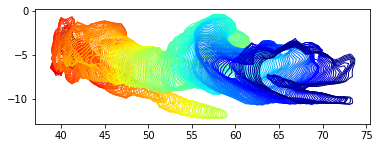

In [165]:
gdf.plot(column='time', facecolor='none', cmap='jet') #, alpha=1) #, legend=True)

/Users/brianmapes/opt/miniconda3/envs/geopy/lib/python3.10/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


Text(0.5, 1.0, 'polygons w/no holes? lasting 7 days, one merger')

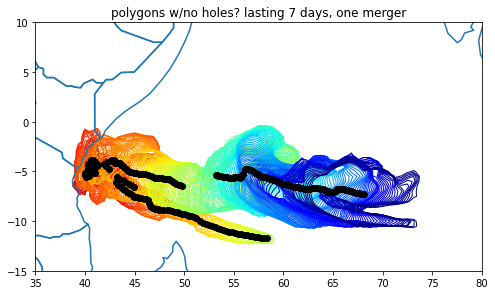

In [166]:
# with map context 
fig, ax = plt.subplots(figsize=[8,7])
ax.set_aspect('equal')
ax.set_xlim(35, 80)
ax.set_ylim(-15,10)

gdf.plot(ax=ax, column='time', facecolor='none', \
                cmap='jet', alpha=1) #, legend=True)

# Plot centroids 
gdf_area.centroid.to_crs(gdf.crs).plot(ax=ax,color='black')

#gdf.boundary.plot(ax=ax, color='black')
path = gp.datasets.get_path('naturalearth_lowres') # Geography background
mapdf = gp.read_file(path)
mapdf.boundary.plot(ax=ax)
    
ax.set_title('polygons w/no holes? lasting 7 days, one merger')

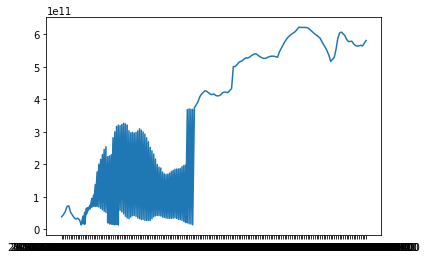

In [167]:
plt.plot(gdf.time, gdf_area.area)

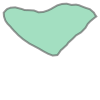

In [168]:
# shape of largest blob at any time 

gdf.iloc[ gdf_area.area.argmax() ].geometry

# Learn about boundary, buffer, centroid

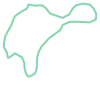

In [169]:
blob = gdf.iloc[ 50 ].geometry
blob.boundary

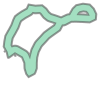

In [170]:
blob.boundary.buffer(0.7, single_sided=True) # units are degrees

In [171]:
blob.bounds, blob.centroid.bounds

((38.959909407818905,
  -8.292618815104166,
  47.47621297836304,
  -1.548028291161381),
 (42.25679859114371,
  -4.090041136659944,
  42.25679859114371,
  -4.090041136659944))

# Time to try rioxarray

In [172]:
import rioxarray as rxr
# from rasterio.plot import show


In [183]:
gdf.geometry

0      POLYGON ((39.37500 -6.01948, 40.00000 -6.05890...
1      POLYGON ((39.37500 -6.20799, 40.00000 -6.10609...
2      POLYGON ((41.25000 -6.51209, 41.30522 -6.50000...
3      POLYGON ((39.37500 -6.56799, 39.46122 -6.50000...
4      POLYGON ((39.37500 -6.56993, 39.46502 -6.50000...
                             ...                        
239    POLYGON ((67.50000 -10.54500, 67.74338 -10.500...
240    POLYGON ((67.50000 -10.56662, 68.01992 -10.500...
241    POLYGON ((67.50000 -10.55310, 68.12500 -10.543...
242    POLYGON ((67.50000 -10.51405, 68.12500 -10.562...
243    POLYGON ((68.12500 -10.57933, 68.52757 -10.500...
Name: geometry, Length: 244, dtype: geometry

In [174]:
# MERRA: get oneself authenticated first 
URL = 'dods://goldsmr4.gesdisc.eosdis.nasa.gov/dods/M2I1NXASM'
#testURL = 'https://goldsmr5.gesdisc.eosdis.nasa.gov/dods/M2I3NPASM'
#testURL = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds084.1/2021/20210719/gfs.0p25.2021071900.f024.grib2'
ds = xr.open_dataset(URL).sel(time=slice(case.firsttime,case.lasttime), lat=slice(-25,25), lon=slice(30,100))
ds

/Users/brianmapes/opt/miniconda3/envs/geopy/lib/python3.10/site-packages/xarray/coding/times.py:144: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


<xarray.Dataset>
Dimensions:  (time: 172, lat: 101, lon: 113)
Coordinates:
  * time     (time) datetime64[ns] 2017-05-21T08:00:00.000003 ... 2017-05-28T...
  * lat      (lat) float64 -25.0 -24.5 -24.0 -23.5 -23.0 ... 23.5 24.0 24.5 25.0
  * lon      (lon) float64 30.0 30.62 31.25 31.88 ... 98.12 98.75 99.38 100.0
Data variables: (12/24)
    disph    (time, lat, lon) float32 ...
    ps       (time, lat, lon) float32 ...
    qv10m    (time, lat, lon) float32 ...
    qv2m     (time, lat, lon) float32 ...
    slp      (time, lat, lon) float32 ...
    t10m     (time, lat, lon) float32 ...
    ...       ...
    u10m     (time, lat, lon) float32 ...
    u2m      (time, lat, lon) float32 ...
    u50m     (time, lat, lon) float32 ...
    v10m     (time, lat, lon) float32 ...
    v2m      (time, lat, lon) float32 ...
    v50m     (time, lat, lon) float32 ...
Attributes:
    title:        MERRA-2 inst1_2d_asm_Nx: 2d,1-Hourly,Instantaneous,Single-L...
    Conventions:  COARDS\nGrADS
    dataType:     Grid
    history:      Thu Jan 19 02:15:29 GMT 2023 : imported by GrADS Data Serve...

In [186]:
ds.rio.clip?

Signature:
ds.rio.clip(
    geometries: Iterable,
    crs: Optional[Any] = None,
    all_touched: bool = False,
    drop: bool = True,
    invert: bool = False,
    from_disk: bool = False,
) -> xarray.core.dataset.Dataset
Docstring:
Crops a :class:`xarray.Dataset` by geojson like geometry dicts in dimensions 'x'/'y'.

.. warning:: Clips variables that have dimensions 'x'/'y'. Others are appended as is.

Powered by `rasterio.features.geometry_mask`.

Examples:

    >>> geometry = ''' {"type": "Polygon",
    ...                 "coordinates": [
    ...                 [[-94.07955380199459, 41.69085871273774],
    ...                 [-94.06082436942204, 41.69103313774798],
    ...                 [-94.06063203899649, 41.67932439500822],
    ...                 [-94.07935807746362, 41.679150041277325],
    ...                 [-94.07955380199459, 41.69085871273774]]]}'''
    >>> cropping_geometries = [geojson.loads(geometry)]
    >>> xds = xarray.open_rasterio('cool_raster.tif')
    >>> 